In [1]:
!nvidia-smi

Tue Jul 14 00:02:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive

drive.mount('./gdrive', force_remount=True)
%cd './gdrive/My Drive/cubricks'

Mounted at ./gdrive
/content/gdrive/My Drive/cubricks


In [3]:
!pip install -q tensorflow-gpu

In [4]:
%tensorflow_version 2.x

import os
import numpy as np
import pandas as pd
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
def organize(df):
    ### Trim string/Remove duplicates ###
    df.columns = df.columns.str.replace(' ', '')

    ### String to datetime format ###
    df['DocumentDate'] = pd.to_datetime(df['DocumentDate'], errors='coerce')
    df['DueDate'] = pd.to_datetime(df['DueDate'], errors='coerce')
    df['ClearingDate'] = pd.to_datetime(df['ClearingDate'], errors='coerce')
    df['LastCreditReview'] = pd.to_datetime(df['LastCreditReview'], errors='coerce')

    ### Drop/Fill null values ###
    df.dropna(subset=['DocumentDate', 'Document', 'DueDate', 'ClearingDate'], inplace=True)
    df[df.columns.drop('LastCreditReview')].fillna(0, inplace=True)

    ### Float to integer ###
    df['Company'] = pd.to_numeric(df['Company'], downcast='integer')
    df['Document'] = pd.to_numeric(df['Document'], downcast='integer')
    df['CustomerCode'] = pd.to_numeric(df['CustomerCode'], downcast='integer')

    ### Amount treatment/filter ###
    df['Amount'] = df['Amount'].apply(lambda x: int(str(x).replace(',', '')))
    # df = df[df['Amount'] > 0]

    return df


df_train = pd.read_csv('InvoicedDocuments_train_v1.csv', na_values=['N/I'])
df_train = organize(df_train)

df_test = pd.read_csv('InvoicedDocuments_test_v2.csv', na_values=['N/I'])
df_test = organize(df_test)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [6]:
def pre_format(df):
    ### String to number ###
    string_number = lambda x: int(''.join(format(ord(w), '') for w in str(x)))
    df['CountryCT'] = df['Country'].apply(string_number)
    df['RegionCT'] = df['Region'].apply(string_number)
    df['TermsCT'] = df['Terms'].apply(string_number)

    ### Generate DaysTo__ ###
    df['DaysToLastCreditReview'] = df['LastCreditReview'] - df['DocumentDate']
    df['DaysToLastCreditReview'] = df['DaysToLastCreditReview'].fillna(pd.Timedelta(seconds=0)).astype('timedelta64[D]').astype(int)
    # df = df[df['DaysToLastCreditReview'] >= -1]

    df['DaysToDue'] = (df['DueDate'] - df['DocumentDate']).astype('timedelta64[D]').astype(int)
    df = df[df['DaysToDue'] > 0]

    df['DaysToClearingDate'] = (df['ClearingDate'] - df['DocumentDate']).astype('timedelta64[D]').astype(int)
    df = df[df['DaysToClearingDate'] > 0]    

    return df


df_train = pre_format(df_train)
df_test = pre_format(df_test)


df_train.info()
df_train.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1837425 entries, 1 to 1887407
Data columns (total 17 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   Company                 int16         
 1   CustomerCode            int32         
 2   Country                 object        
 3   Region                  object        
 4   LastCreditReview        datetime64[ns]
 5   DocumentDate            datetime64[ns]
 6   Document                int32         
 7   DueDate                 datetime64[ns]
 8   ClearingDate            datetime64[ns]
 9   Terms                   object        
 10  Amount                  int64         
 11  CountryCT               int64         
 12  RegionCT                int64         
 13  TermsCT                 int64         
 14  DaysToLastCreditReview  int64         
 15  DaysToDue               int64         
 16  DaysToClearingDate      int64         
dtypes: datetime64[ns](4), int16(1), int32(2), int6

,Company,CustomerCode,Country,Region,LastCreditReview,DocumentDate,Document,DueDate,ClearingDate,Terms,Amount,CountryCT,RegionCT,TermsCT,DaysToLastCreditReview,DaysToDue,DaysToClearingDate
1,1,76075,AU,QLD,NaT,2018-01-29,926499904,2018-02-09,2018-02-07,N10,8826,6585,817668,784948,0,11,9
2,1,76075,AU,QLD,NaT,2018-01-29,926499903,2018-02-09,2018-02-07,N10,9356,6585,817668,784948,0,11,9
3,1,70658,CN,220,NaT,2018-01-29,926505309,2018-03-06,2018-03-16,E5/5,46461,6778,505048,69534753,0,36,46
4,1,74676,FR,01,NaT,2018-01-29,926497847,2018-02-28,2018-03-01,E3/7,26956,7082,4849,69514755,0,30,31
5,1,76200,MT,MT,NaT,2018-01-29,926497640,2018-03-20,2018-03-12,JC50,22730,7784,7784,74675348,0,50,42
6,1,76200,MT,MT,NaT,2018-01-29,926498999,2018-03-20,2018-03-12,JC50,22730,7784,7784,74675348,0,50,42
7,1,76200,MT,MT,NaT,2018-01-29,926499000,2018-03-20,2018-03-12,JC50,22730,7784,7784,74675348,0,50,42
8,1,76200,MT,MT,NaT,2018-01-29,926497637,2018-03-20,2018-03-05,JC50,22568,7784,7784,74675348,0,50,35
9,1,76200,MT,MT,NaT,2018-01-29,926497634,2018-03-20,2018-03-05,JC50,22568,7784,7784,74675348,0,50,35
10,1,76200,MT,MT,NaT,2018-01-29,926497639,2018-03-20,2018-03-05,JC50,22730,7784,7784,74675348,0,50,35


In [7]:
# def late(df, test=False):
#     ### Define IsLate ###
#     df['IsLate'] = 0 if test else (df['DueDate'] - df['ClearingDate']).astype('timedelta64[D]').astype(int)
#     df['IsLate'] = df['IsLate'].apply(lambda x: 0 if x > 0 else 1)

#     return df

# df_train = late(df_train)
# df_test = late(df_test, test=True)

# sns.countplot(df_train['IsLate'])
# df_train.head(10)

,Company,CustomerCode,Country,Region,LastCreditReview,DocumentDate,Document,DueDate,ClearingDate,Terms,Amount,CountryCT,RegionCT,TermsCT,DaysToLastCreditReview,DaysToDue,DaysToClearingDate,ClearingDateRange,ClearingDateRangeCT,DaysToDueRange,DaysToDueRangeCT
1,1,76075,AU,QLD,NaT,2018-01-29,926499904,2018-02-09,2018-02-07,N10,8826,6585,817668,784948,0,11,9,8-14,1,8-14,1
2,1,76075,AU,QLD,NaT,2018-01-29,926499903,2018-02-09,2018-02-07,N10,9356,6585,817668,784948,0,11,9,8-14,1,8-14,1
3,1,70658,CN,220,NaT,2018-01-29,926505309,2018-03-06,2018-03-16,E5/5,46461,6778,505048,69534753,0,36,46,29-inf,4,29-inf,4
4,1,74676,FR,01,NaT,2018-01-29,926497847,2018-02-28,2018-03-01,E3/7,26956,7082,4849,69514755,0,30,31,29-inf,4,29-inf,4
5,1,76200,MT,MT,NaT,2018-01-29,926497640,2018-03-20,2018-03-12,JC50,22730,7784,7784,74675348,0,50,42,29-inf,4,29-inf,4
6,1,76200,MT,MT,NaT,2018-01-29,926498999,2018-03-20,2018-03-12,JC50,22730,7784,7784,74675348,0,50,42,29-inf,4,29-inf,4
7,1,76200,MT,MT,NaT,2018-01-29,926499000,2018-03-20,2018-03-12,JC50,22730,7784,7784,74675348,0,50,42,29-inf,4,29-inf,4
8,1,76200,MT,MT,NaT,2018-01-29,926497637,2018-03-20,2018-03-05,JC50,22568,7784,7784,74675348,0,50,35,29-inf,4,29-inf,4
9,1,76200,MT,MT,NaT,2018-01-29,926497634,2018-03-20,2018-03-05,JC50,22568,7784,7784,74675348,0,50,35,29-inf,4,29-inf,4
10,1,76200,MT,MT,NaT,2018-01-29,926497639,2018-03-20,2018-03-05,JC50,22730,7784,7784,74675348,0,50,35,29-inf,4,29-inf,4


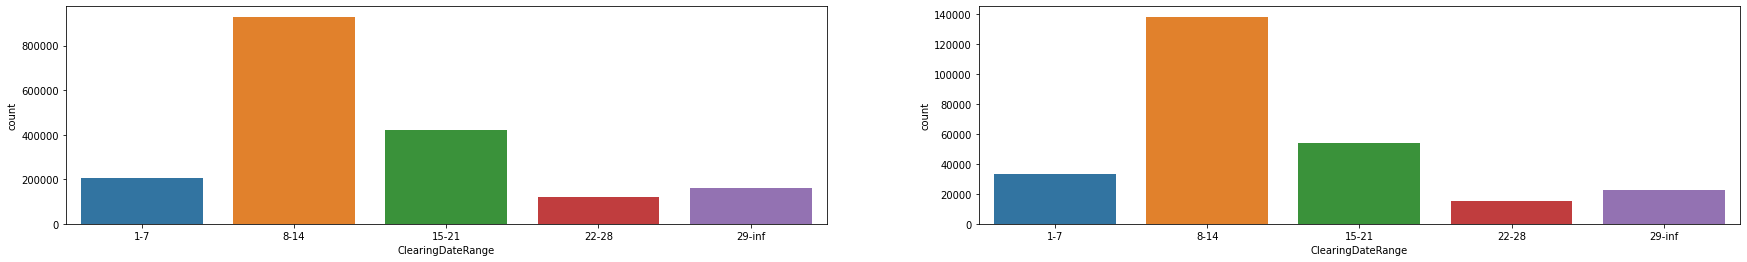

In [8]:
def add_ranges(df, bins, labels):
    ### Define ClearingDateRange and Categorize ###
    df['ClearingDateRange'] = pd.cut(df['DaysToClearingDate'], bins=bins, labels=labels, right=False, include_lowest=True)
    df[['ClearingDateRangeCT']] = df[['ClearingDateRange']].apply(lambda x: pd.Categorical(x, ordered=True).codes)

    df['DaysToDueRange'] = pd.cut(df['DaysToDue'], bins=bins, labels=labels, right=False, include_lowest=True)
    df[['DaysToDueRangeCT']] = df[['DaysToDueRange']].apply(lambda x: pd.Categorical(x, ordered=True).codes)

    return df

bins = [1, 8, 15, 22, 29, np.inf]
labels = [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins[:-1]))]

df_train = add_ranges(df_train, bins, labels)
df_test = add_ranges(df_test, bins, labels)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 4))
sns.countplot(df_train['ClearingDateRange'], ax=ax[0])
sns.countplot(df_test['ClearingDateRange'], ax=ax[1])
df_train.head(10)

,Company,CustomerCode,Country,Region,LastCreditReview,DocumentDate,Document,DueDate,ClearingDate,Terms,Amount,CountryCT,RegionCT,TermsCT,DaysToLastCreditReview,DaysToDue,DaysToClearingDate,ClearingDateRange,ClearingDateRangeCT,DaysToDueRange,DaysToDueRangeCT,DocumentMonth,DocumentDay,DocumentWeekDay,DueMonth,DueDay,DueWeekDay
1,1,76075,AU,QLD,NaT,2018-01-29,926499904,2018-02-09,2018-02-07,N10,8826,6585,817668,784948,0,11,9,8-14,1,8-14,1,1,29,0,2,9,4
2,1,76075,AU,QLD,NaT,2018-01-29,926499903,2018-02-09,2018-02-07,N10,9356,6585,817668,784948,0,11,9,8-14,1,8-14,1,1,29,0,2,9,4
3,1,70658,CN,220,NaT,2018-01-29,926505309,2018-03-06,2018-03-16,E5/5,46461,6778,505048,69534753,0,36,46,29-inf,4,29-inf,4,1,29,0,3,6,1
4,1,74676,FR,01,NaT,2018-01-29,926497847,2018-02-28,2018-03-01,E3/7,26956,7082,4849,69514755,0,30,31,29-inf,4,29-inf,4,1,29,0,2,28,2
5,1,76200,MT,MT,NaT,2018-01-29,926497640,2018-03-20,2018-03-12,JC50,22730,7784,7784,74675348,0,50,42,29-inf,4,29-inf,4,1,29,0,3,20,1
6,1,76200,MT,MT,NaT,2018-01-29,926498999,2018-03-20,2018-03-12,JC50,22730,7784,7784,74675348,0,50,42,29-inf,4,29-inf,4,1,29,0,3,20,1
7,1,76200,MT,MT,NaT,2018-01-29,926499000,2018-03-20,2018-03-12,JC50,22730,7784,7784,74675348,0,50,42,29-inf,4,29-inf,4,1,29,0,3,20,1
8,1,76200,MT,MT,NaT,2018-01-29,926497637,2018-03-20,2018-03-05,JC50,22568,7784,7784,74675348,0,50,35,29-inf,4,29-inf,4,1,29,0,3,20,1
9,1,76200,MT,MT,NaT,2018-01-29,926497634,2018-03-20,2018-03-05,JC50,22568,7784,7784,74675348,0,50,35,29-inf,4,29-inf,4,1,29,0,3,20,1
10,1,76200,MT,MT,NaT,2018-01-29,926497639,2018-03-20,2018-03-05,JC50,22730,7784,7784,74675348,0,50,35,29-inf,4,29-inf,4,1,29,0,3,20,1


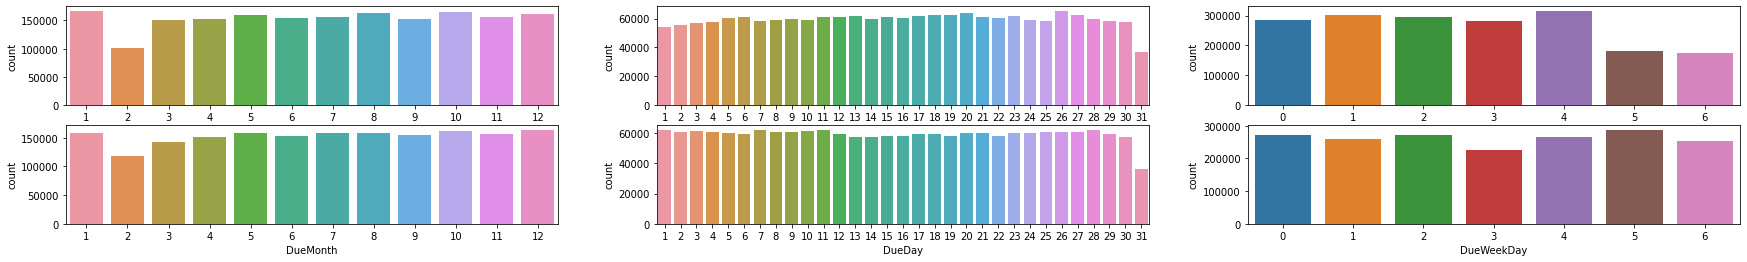

In [9]:
def add_days(df):
    ### Extract Document/Due month, day, weekday ###
    df['DocumentMonth'] = df['DocumentDate'].dt.month
    df['DocumentDay'] = df['DocumentDate'].dt.day
    df['DocumentWeekDay'] = df['DocumentDate'].dt.weekday

    df['DueMonth'] = df['DueDate'].dt.month
    df['DueDay'] = df['DueDate'].dt.day
    df['DueWeekDay'] = df['DueDate'].dt.weekday

    return df


df_train = add_days(df_train)
df_test = add_days(df_test)


fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 4))
sns.countplot(df_train['DocumentMonth'], ax=ax[0,0])
sns.countplot(df_train['DocumentDay'], ax=ax[0,1])
sns.countplot(df_train['DocumentWeekDay'], ax=ax[0,2])

sns.countplot(df_train['DueMonth'], ax=ax[1,0])
sns.countplot(df_train['DueDay'], ax=ax[1,1])
sns.countplot(df_train['DueWeekDay'], ax=ax[1,2])

df_train.head(10)

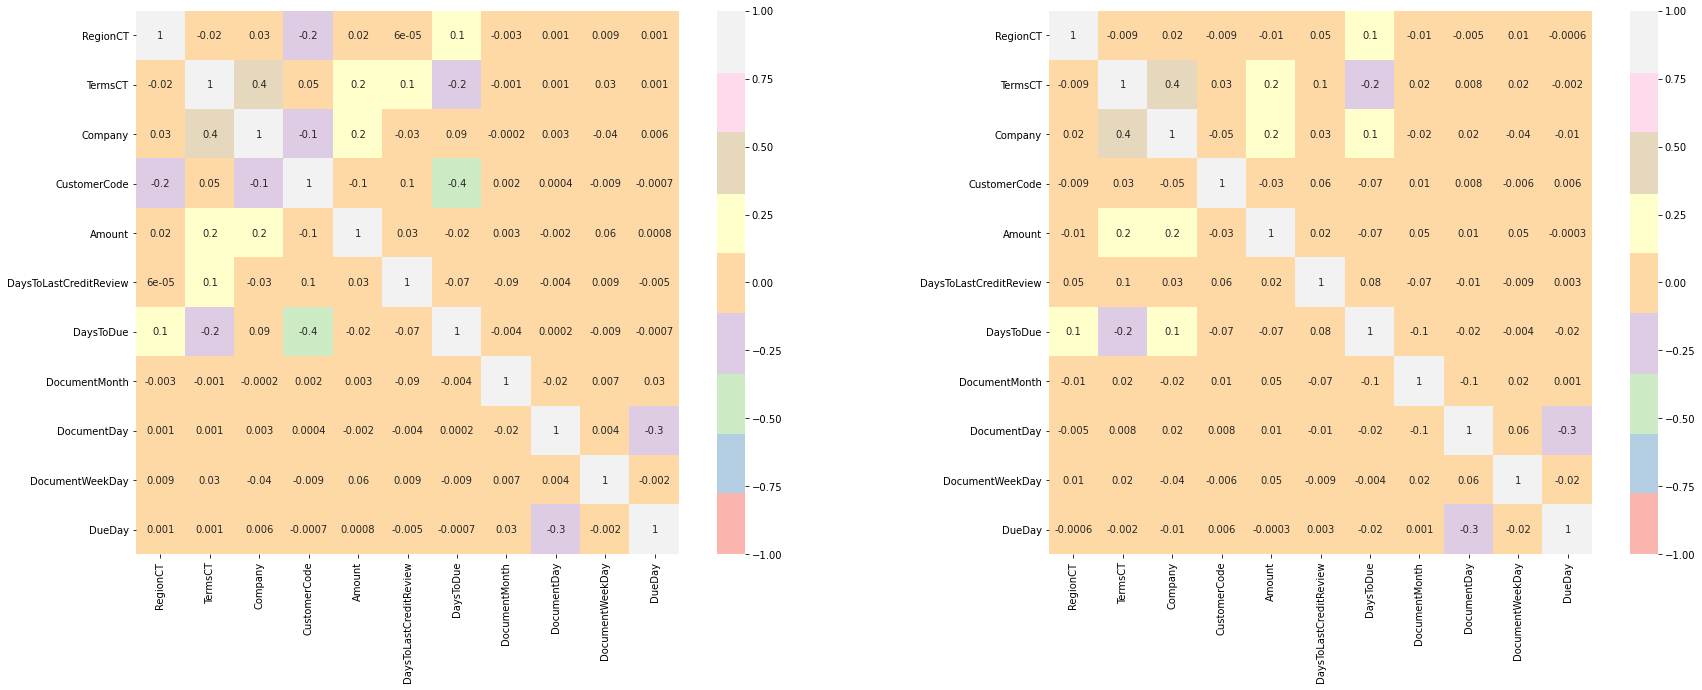

In [16]:
y_column = np.array(['ClearingDateRangeCT'])
features = np.array([
                    #  'ClearingDateRangeCT',
                    #  'DaysToClearingDate',
                    #  'Document',
                    #  'DaysToDueRangeCT',
                    #  'CountryCT',
                     'RegionCT',
                     'TermsCT',
                     'Company',
                     'CustomerCode',
                     'Amount',
                     'DaysToLastCreditReview',
                     'DaysToDue',
                    #  'IsLate',
                     'DocumentMonth',
                     'DocumentDay',
                     'DocumentWeekDay',
                    #  'DueMonth',
                     'DueDay',
                    #  'DueWeekDay',
                     ])


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
sns.heatmap(df_train[features].corr(), square=True, annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, cmap='Pastel1', ax=ax[0])
sns.heatmap(df_test[features].corr(), square=True, annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, cmap='Pastel1', ax=ax[1])

In [17]:
x_train, y_train = df_train[features].values, df_train[y_column].values
x_test, y_test = df_test[features].values, df_test[y_column].values

# x_train, y_train = df_test[features].values, df_test[y_column].values
# x_test, y_test = df_train[features].values, df_train[y_column].values

In [12]:
# dumb predict
print(f'Total items: {len(y_test)}')

for i in range(len(labels)):
    dumb_data = np.ones(y_test.shape, dtype=np.int) * i
    print(f'Always predicting the range "{i}", accuracy is {accuracy_score(y_test, dumb_data) * 100:.2f}%')

Total items: 262007
Always predicting the range "0", accuracy is 12.58%
Always predicting the range "1", accuracy is 52.72%
Always predicting the range "2", accuracy is 20.48%
Always predicting the range "3", accuracy is 5.75%
Always predicting the range "4", accuracy is 8.48%


In [13]:
print(f'Always predicting the range of "DueRange", accuracy is {accuracy_score(y_test, df_test["DaysToDueRangeCT"].values) * 100:.2f}%')

cm_report = classification_report(y_test, df_test["DaysToDueRangeCT"].values, target_names=labels)
print(cm_report)

Always predicting the range of "DueRange", accuracy is 62.98%
              precision    recall  f1-score   support

         1-7       0.43      0.07      0.12     32964
        8-14       0.69      0.88      0.78    138129
       15-21       0.53      0.49      0.51     53648
       22-28       0.34      0.21      0.26     15053
      29-inf       0.52      0.51      0.52     22213

    accuracy                           0.63    262007
   macro avg       0.50      0.43      0.44    262007
weighted avg       0.59      0.63      0.59    262007



In [18]:
random_forest = RandomForestClassifier(n_estimators=10, criterion='gini', random_state=42, n_jobs=-1)
random_forest.fit(x_train, np.squeeze(y_train))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Total items: 262007
Accuracy: 68.85%

Feature ranking:
0.17838065235980147	Amount
0.1575377933197804	DaysToDue
0.1187828901580453	CustomerCode
0.10986638163463489	DaysToLastCreditReview
0.08445103317244593	TermsCT
0.07190893533673193	RegionCT
0.06254928707507433	DueDay
0.061309119818959	DocumentDay
0.05639320422559385	DocumentWeekDay
0.056330573504315105	DocumentMonth
0.04249012939461765	Company


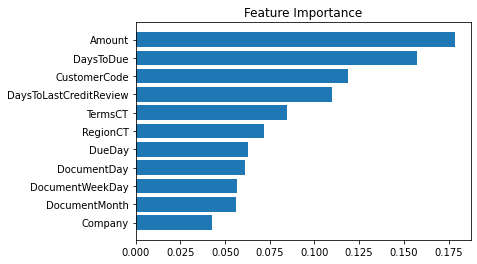

In [19]:
predict = random_forest.predict(x_test)

importances = random_forest.feature_importances_
indices = np.argsort(importances)[::-1]

print(f'Total items: {len(y_test)}')
print(f'Accuracy: {accuracy_score(y_test, predict) * 100:.2f}%\n')
print(f'Feature ranking:')

for f in range(x_train.shape[1]):
    print(f'{importances[indices[f]]}\t{features[indices[f]]}')

plt.barh(range(x_train.shape[1]), importances[indices])
plt.yticks(range(x_train.shape[1]), features[indices])
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [20]:
cm_report = classification_report(y_test, predict, target_names=labels)
print(cm_report)

              precision    recall  f1-score   support

         1-7       0.57      0.45      0.51     32964
        8-14       0.76      0.86      0.80    138129
       15-21       0.63      0.55      0.59     53648
       22-28       0.38      0.31      0.34     15053
      29-inf       0.64      0.57      0.60     22213

    accuracy                           0.69    262007
   macro avg       0.60      0.55      0.57    262007
weighted avg       0.68      0.69      0.68    262007



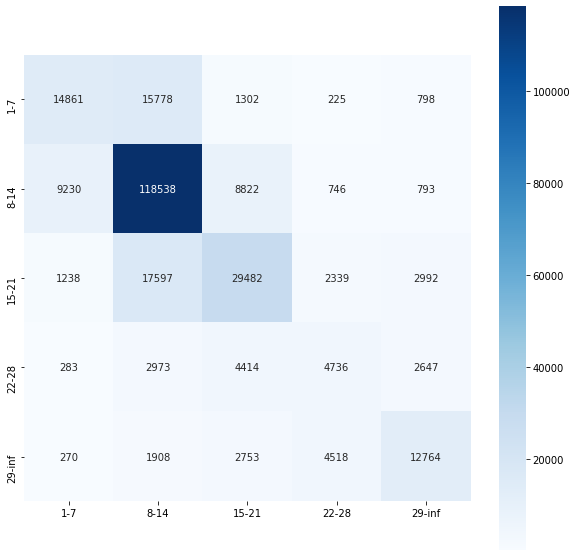

In [21]:
cm = confusion_matrix(y_test, predict)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, square=True, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

In [22]:
def binary_encoding(df, columns, maxlength):
  for item in columns:
    col = np.array([str('{0:b}'.format(x)) for x in df[item].values])
    header = np.array([f'{item}{i}' for i in range(maxlength)])
    newcol = np.zeros((col.shape[0], maxlength), dtype=np.int8)

    for i in range(len(col)):
      a = np.array(list(col[i]), dtype=np.int8)
      newcol[i][maxlength - len(a):] = a

    df2 = pd.DataFrame(newcol, columns=header)

    df.reset_index(drop=True, inplace=True)
    df = pd.concat([df, df2], axis=1)

  df.drop(columns=columns, inplace=True)
  return df


df_network_train = df_train[features].copy()
df_network_test = df_test[features].copy()

columns = ['CustomerCode', 'Company', 'RegionCT', 'TermsCT', 'DocumentMonth', 'DocumentDay', 'DocumentWeekDay', 'DueDay']
maxlength = [32, 32, 32, 32, 4, 5, 3, 5]

for col, length in zip(columns, maxlength):
    df_network_train = binary_encoding(df_network_train, [col], maxlength=length)
    df_network_test = binary_encoding(df_network_test, [col], maxlength=length)

df_network_train.head(10)

,Amount,DaysToLastCreditReview,DaysToDue,CustomerCode0,CustomerCode1,CustomerCode2,CustomerCode3,CustomerCode4,CustomerCode5,CustomerCode6,CustomerCode7,CustomerCode8,CustomerCode9,CustomerCode10,CustomerCode11,CustomerCode12,CustomerCode13,CustomerCode14,CustomerCode15,CustomerCode16,CustomerCode17,CustomerCode18,CustomerCode19,CustomerCode20,CustomerCode21,CustomerCode22,CustomerCode23,CustomerCode24,CustomerCode25,CustomerCode26,CustomerCode27,CustomerCode28,CustomerCode29,CustomerCode30,CustomerCode31,Company0,Company1,Company2,Company3,Company4,...,TermsCT9,TermsCT10,TermsCT11,TermsCT12,TermsCT13,TermsCT14,TermsCT15,TermsCT16,TermsCT17,TermsCT18,TermsCT19,TermsCT20,TermsCT21,TermsCT22,TermsCT23,TermsCT24,TermsCT25,TermsCT26,TermsCT27,TermsCT28,TermsCT29,TermsCT30,TermsCT31,DocumentMonth0,DocumentMonth1,DocumentMonth2,DocumentMonth3,DocumentDay0,DocumentDay1,DocumentDay2,DocumentDay3,DocumentDay4,DocumentWeekDay0,DocumentWeekDay1,DocumentWeekDay2,DueDay0,DueDay1,DueDay2,DueDay3,DueDay4
0,8826,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,...,0,0,0,1,0,1,1,1,1,1,1,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,1,1,1,1,0,1,0,0,0,0,1,0,0,1
1,9356,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,...,0,0,0,1,0,1,1,1,1,1,1,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,1,1,1,1,0,1,0,0,0,0,1,0,0,1
2,46461,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,1,1,0,1,0,0,0,0,0,1,1,0
3,26956,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,1,0,1,1,0,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,1,1,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1,1,1,1,0,1,0,0,0,1,1,1,0,0
4,22730,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,...,1,1,1,0,0,1,1,0,1,1,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,0,1,0,0
5,22730,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,...,1,1,1,0,0,1,1,0,1,1,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,0,1,0,0
6,22730,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,...,1,1,1,0,0,1,1,0,1,1,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,0,1,0,0
7,22568,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,...,1,1,1,0,0,1,1,0,1,1,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,0,1,0,0
8,22568,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,...,1,1,1,0,0,1,1,0,1,1,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,0,1,0,0
9,22730,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,...,1,1,1,0,0,1,1,0,1,1,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,0,1,0,0


In [23]:
x_train, x_valid, y_train, y_valid = train_test_split(df_network_train.values,
                                                      df_train[y_column].values,
                                                      test_size=0.1, 
                                                      shuffle=True,
                                                      random_state=42,
                                                      stratify=df_train[y_column].values)

y_train_categorical = tf.keras.utils.to_categorical(y_train)
y_valid_categorical = tf.keras.utils.to_categorical(y_valid)

In [40]:
def create_model():
    model = tf.keras.models.Sequential(name='cubricks')

    model.add(tf.keras.layers.Input(shape=df_network_train.values.shape[1]))
    model.add(tf.keras.layers.BatchNormalization(renorm=True))

    model.add(tf.keras.layers.Dense(2048, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(renorm=True))
    model.add(tf.keras.layers.Dropout(rate=0.1))

    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(renorm=True))
    model.add(tf.keras.layers.Dropout(rate=0.1))

    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(renorm=True))
    model.add(tf.keras.layers.Dropout(rate=0.1))

    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(renorm=True))

    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(renorm=True))

    model.add(tf.keras.layers.Dense(len(labels), activation='softmax'))
    return model


model = create_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-8, amsgrad=True),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1, reduction='none'),
              metrics=['accuracy'])

model.summary()

Model: "cubricks"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_18 (Batc (None, 148)               1036      
_________________________________________________________________
dense_18 (Dense)             (None, 2048)              305152    
_________________________________________________________________
batch_normalization_19 (Batc (None, 2048)              14336     
_________________________________________________________________
dropout_9 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_20 (Batc (None, 1024)              7168      
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0  

In [32]:
logdir = os.path.join('.', 'output')
training_log = os.path.join(logdir, 'training.txt')
model_checkpoint = os.path.join(logdir, 'model.hdf5')

# os.makedirs(logdir, exist_ok=True)

# if os.path.isfile(model_checkpoint):
#     model.load_weights(model_checkpoint)

callbacks = [
    # tf.keras.callbacks.TensorBoard(logdir, profile_batch=0),
    # tf.keras.callbacks.CSVLogger(training_log, separator=',', append=True),
    # tf.keras.callbacks.ModelCheckpoint(model_checkpoint, monitor='val_loss', save_best_only=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_delta=1e-8, factor=0.2, patience=15, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-8, patience=20, restore_best_weights=True, verbose=1),
]

In [41]:
model.fit(x_train,
          y_train_categorical,
          validation_data=(x_valid, y_valid_categorical),
          callbacks=callbacks,
          batch_size=2048,
          epochs=10000,
          verbose=1)

Epoch 1/10000
808/808 [==============================] - 13s 16ms/step - loss: 1.9416 - accuracy: 0.7276 - val_loss: 0.8444 - val_accuracy: 0.7666 - lr: 0.0010
Epoch 2/10000
808/808 [==============================] - 13s 16ms/step - loss: 0.8320 - accuracy: 0.7747 - val_loss: 0.8072 - val_accuracy: 0.7876 - lr: 0.0010
Epoch 3/10000
808/808 [==============================] - 13s 16ms/step - loss: 0.8036 - accuracy: 0.7898 - val_loss: 0.7872 - val_accuracy: 0.7984 - lr: 0.0010
Epoch 4/10000
808/808 [==============================] - 13s 16ms/step - loss: 0.7840 - accuracy: 0.7999 - val_loss: 0.7748 - val_accuracy: 0.8049 - lr: 0.0010
Epoch 5/10000
808/808 [==============================] - 13s 16ms/step - loss: 0.7690 - accuracy: 0.8080 - val_loss: 0.7627 - val_accuracy: 0.8113 - lr: 0.0010
Epoch 6/10000
808/808 [==============================] - 13s 16ms/step - loss: 0.7564 - accuracy: 0.8151 - val_loss: 0.7544 - val_accuracy: 0.8166 - lr: 0.0010
Epoch 7/10000
808/808 [=================

In [42]:
predict = np.argmax(model.predict(df_network_test.values), axis=1)

print(f'Total: {len(df_test[y_column].values)}')
print(f'Accuracy: {accuracy_score(df_test[y_column].values, predict) * 100:.2f}%')

Total: 262007
Accuracy: 69.58%


In [43]:
cm_report = classification_report(df_test[y_column].values, predict, target_names=labels)
print(cm_report)

              precision    recall  f1-score   support

         1-7       0.62      0.50      0.56     32964
        8-14       0.77      0.86      0.81    138129
       15-21       0.63      0.56      0.59     53648
       22-28       0.34      0.33      0.33     15053
      29-inf       0.63      0.51      0.56     22213

    accuracy                           0.70    262007
   macro avg       0.60      0.55      0.57    262007
weighted avg       0.69      0.70      0.69    262007



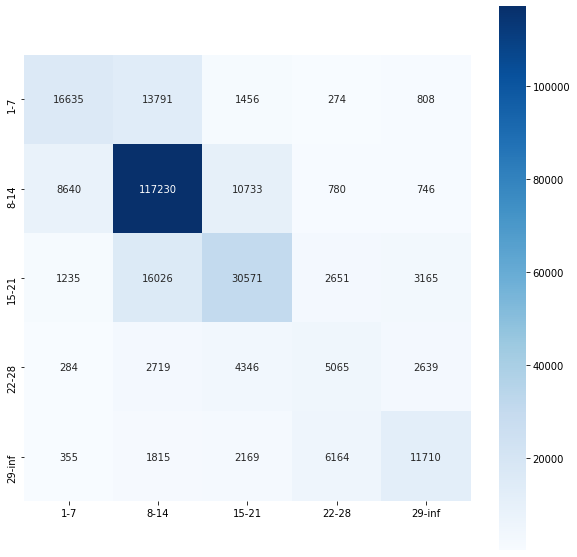

In [36]:
cm = confusion_matrix(df_test[y_column].values, predict)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, square=True, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)